In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Project Overview

### Goal:
    - The goal of this project is to develop a effective model which can use simple customer features to accurately predict client churn. 


### Business Utility: 
    - Identifying clients at high risk of churn gives us actionable intelligence in two phases.
    
        - Potential Customer Identification: By being able to quantify which charateristics make a customer likely to stay or go we can more
        tailor our marketing efforts to attract customers who are more likely to remain customers.
        
        - Utilize targeted marketing and retainment efforts at current customers who are higher risk of churn.

### Methodology: 

    - We will be using a logistic regression model which classifies customers as secure (1), or likely to churn(0).
    - There a few advantages of this model and approach:
        - It is a simple model whcih can easily be tweaked or updated for future use.
        - It is cheap to both build and maintain. 
        - It is intuitive, we input non complicated data about clients (age, gender, credit score etc.) and are able to make predictions with accuracy. 

## Exploratory Data Analysis

### Import and high-level overview

In [6]:
# Import and preview our data set
df = pd.read_csv('/Users/elias_m/Desktop/Projects /Bank Churn/train.csv')
df_test = pd.read_csv('/Users/elias_m/Desktop/Projects /Bank Churn/train.csv')
df.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1,0,181449.98,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1,1,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1,0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1,1,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1,1,15068.83,0


In [6]:
# the following cells give us a high level overview, of the count, average and median of our dataset. 
df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  int64  
 11  IsActiveMember   165034 non-null  int64  
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 17.6+ MB


In [136]:
df_churned = df[df['Exited'] ==1]
df_retained = df[df['Exited'] == 0]

num_variables = ['CreditScore','Age','Tenure','Balance','NumOfProducts']

average_comparison_table = pd.DataFrame({
    'retained': df_retained[num_variables].mean(),
    'churned': df_churned[num_variables].mean(),
})
average_comparison_table['diff'] = average_comparison_table['churned']-average_comparison_table['retained']

std_churned = df_churned[num_variables].std()
std_retained = df_retained[num_variables].std()

pooled_std = np.sqrt((std_churned**2 + std_retained**2) / 2)

average_comparison_table['Z-Score Diff'] = (average_comparison_table['retained']-average_comparison_table['churned'])/pooled_std

In [141]:
average_comparison_table

,retained,churned,diff,Z-Score Diff
CreditScore,657.590710,652.220469,-5.370241,0.066741
Age,36.560480,43.958478,7.397997,-0.861550
Tenure,5.048796,4.914378,-0.134418,0.047779
Balance,51255.807752,71209.978085,19954.170333,-0.319682
NumOfProducts,1.615273,1.327854,-0.287419,0.491911


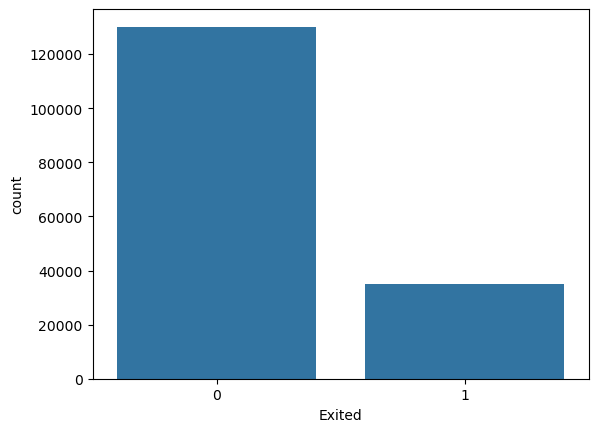

In [119]:
ax = sns.countplot(x='Exited',data = df)

plt.show()

### Visualizations

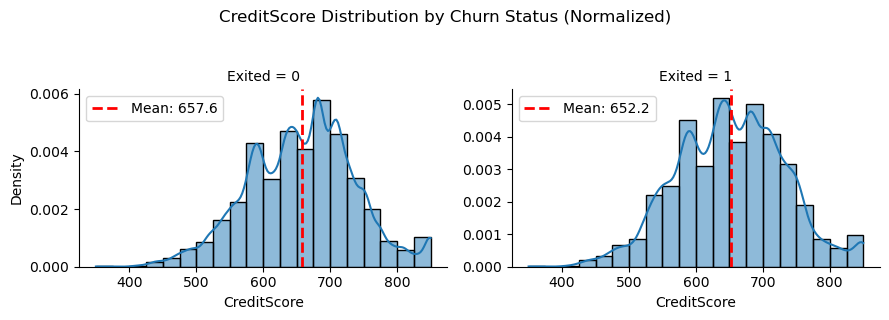

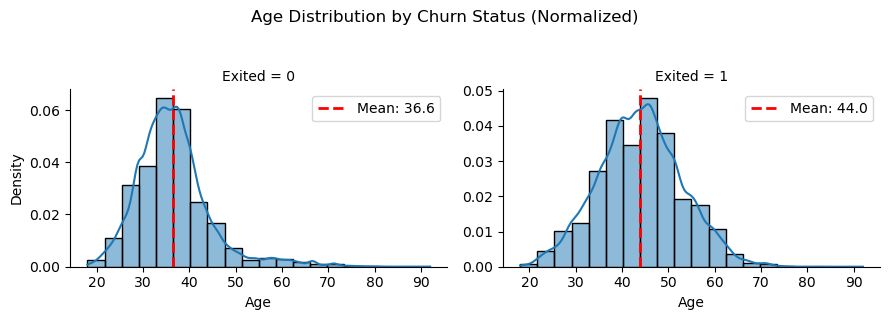

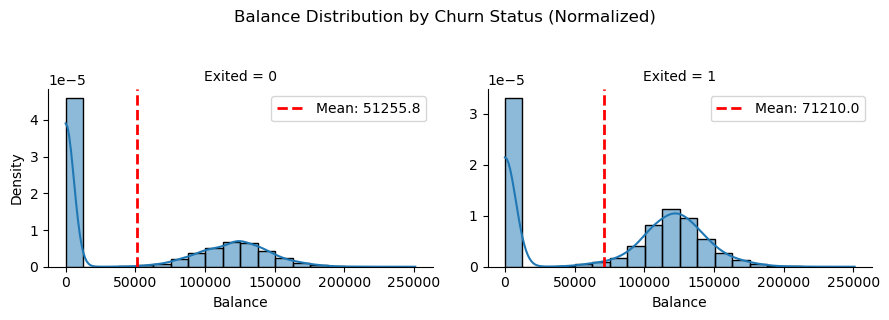

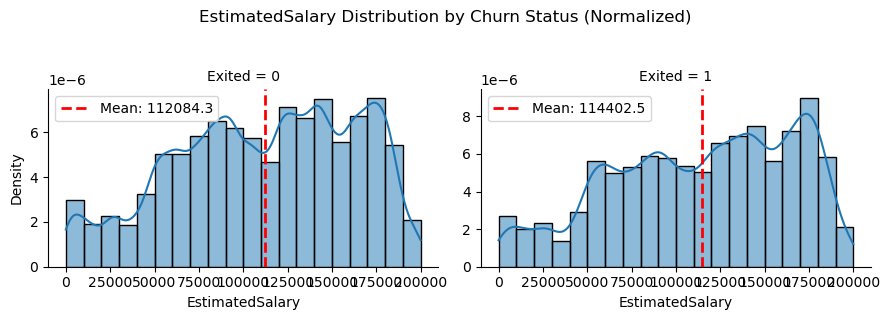

In [76]:

variables = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

for var in variables:
    # Create the facet grid
    g = sns.displot(
        data=df,
        x=var,
        col='Exited',            # Separate by churn status
        bins=20,
        kde=True,
        stat='density',
        common_norm=False,
        facet_kws={'sharey': False},
        height = 3,
        aspect = 1.5
    )

    # Loop over each subplot to add mean lines and labels
    for ax, (churn_val, sub_df) in zip(g.axes.flat, df.groupby('Exited')):
        mean_val = sub_df[var].mean()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
        ax.legend()

    g.fig.suptitle(f'{var} Distribution by Churn Status (Normalized)', y=1.05)
    plt.tight_layout()
    plt.show()

<Axes: xlabel='Exited', ylabel='CreditScore'>

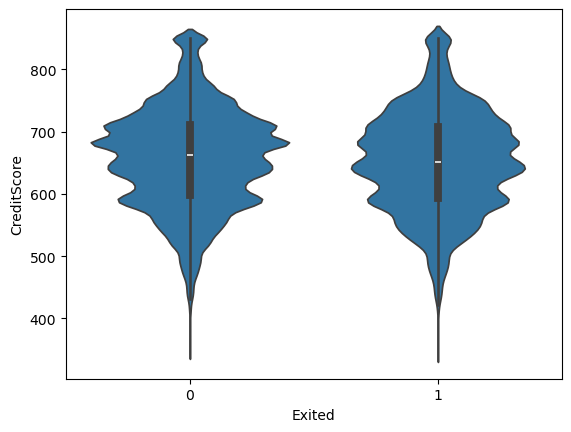

In [12]:
sns.violinplot(x='Exited',y='CreditScore',data = df)

In [56]:
exit_df = pd.DataFrame({'portion':df.Exited.value_counts(normalize= True),
                        'counts':df['Exited'].value_counts()})
exit_df

,portion,counts
Exited,,
0,0.788401,130113
1,0.211599,34921


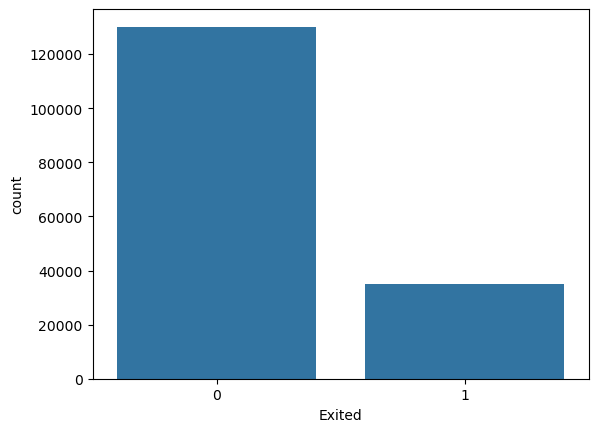

In [15]:
df_corr = df.drop('CustomerId', axis = 1)

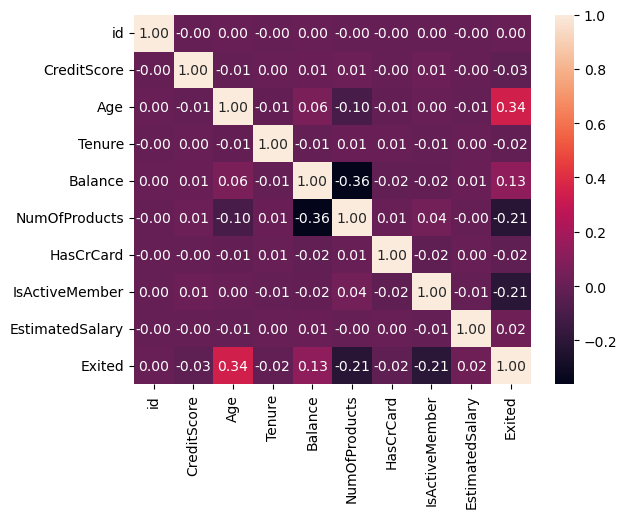

In [16]:
sns.heatmap(data=df_corr.corr(numeric_only=True), annot=True,fmt = '.2f')
plt.show()

In [17]:
df_corr.corr(numeric_only=True)['Exited'].sort_values(ascending=False)

Exited             1.000000
Age                0.340768
Balance            0.129743
EstimatedSalary    0.018827
id                 0.002512
Tenure            -0.019565
HasCrCard         -0.022141
CreditScore       -0.027383
IsActiveMember    -0.210237
NumOfProducts     -0.214554
Name: Exited, dtype: float64

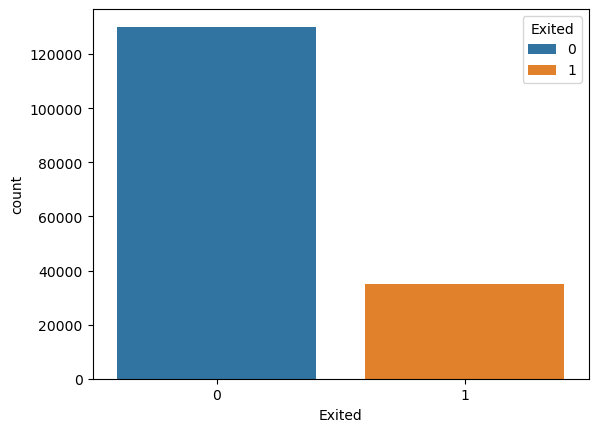

In [18]:
sns.countplot(data=df, x='Exited',hue = 'Exited')
plt.show()

In [19]:
df.groupby('Exited')['Age'].mean()

Exited
0    36.560480
1    43.958478
Name: Age, dtype: float64

<Axes: xlabel='Exited', ylabel='Age'>

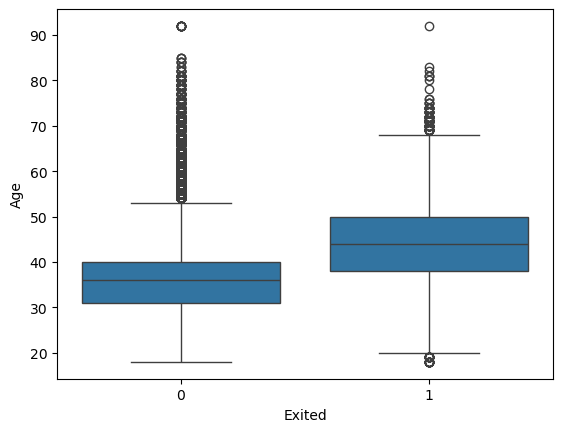

In [20]:
sns.boxplot(data=df,x='Exited',y='Age')


In [21]:
# Here we seperate the data into sets of churned and non_churned customers

In [22]:
churned_df = df[df['Exited']==1]

In [23]:
non_churned_df = df[df['Exited']==0]

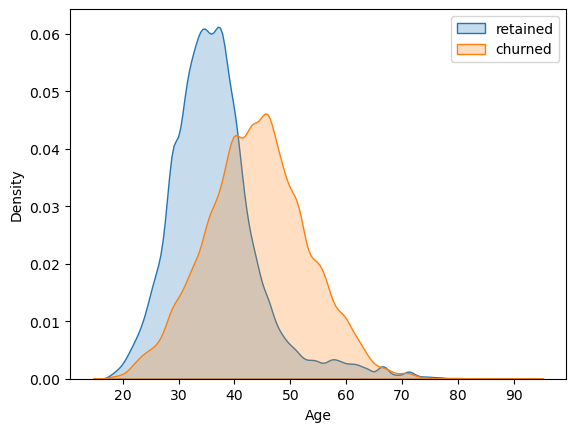

In [24]:
fig1,ax1 = plt.subplots()
sns.kdeplot(non_churned_df['Age'],fill = True,ax=ax1,label='retained')
sns.kdeplot(churned_df['Age'], fill = True,ax=ax1,label='churned')

ax1.legend()

plt.show()

#### Exploration Summary

- The strongest indicator a customer will remain is account activity, followed by the number of products they have with us.
- Alarmingly, higher income and account balances are associated with higher churn.
- Age is the strongest predictor of churn, domain knowledge is need to evaluate the cause.

      - Questions:
          - Are customers passing away an explanation for age's correlation with churn?
          - Is this explained by income and account balance increasing with age?
          - Also, something that requires exploration is why increased balances and salary are increased with higher churn. Losing high value clients is an area of concern


## Model Implementation

### Data Transformation Pipeline

Before we can use it for our model our data must be transformed. We will scale our numerical values and one_hot_encode our categorical data. 

In [27]:
#Here we will import the tools needed for manipulating our data and implementing our model
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [36]:
# Separating our features from our target variables and splitting our data into training and testing sets

X_train = df.drop(['Surname','Exited','CustomerId','id'],axis=1)
y_train = df['Exited']

X_test = df_test.drop(['Surname','CustomerId','Exited','id'],axis =1)
y_test = df_test['Exited']

In [39]:
X_train.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

In [41]:

# For processing purposes we must identify our numerical and categorical features

categorical_columns = ['Geography','Gender']
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']



In [43]:
# frist we will construct our preprocessor, for scaling/encoding our numerical/categorical variables respectively

preprocessor = ColumnTransformer([
    ('num_columns',StandardScaler(),numerical_columns),
    ('cat_columns',OneHotEncoder(drop='first'),categorical_columns),
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 450))
    ])


In [45]:
# now we will fit our training data

model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_columns',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat_columns',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(max_iter=450))])

In [47]:
y_pred = model.predict(X_test)

## Initial Model Performance

In [50]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay

In [52]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.8341311487329883

In [54]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90    130113
           1       0.70      0.38      0.49     34921

    accuracy                           0.83    165034
   macro avg       0.77      0.67      0.70    165034
weighted avg       0.82      0.83      0.81    165034



Our model had an accuracy of 84%, however, our model was lacking in accurately predicting customers who did churn.
We will make a few tweaks and see if we can build a more accurate model. 

## Optimizing Model Accuracy by Adjusting Hyperparameters
Our model needs improvments. We will attempt to tune it by using a CV Grid Search to identify optimal hyperparemeters

In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'classifier__penalty': ['l2','l1'],
    'classifier__C': [0.0001,0.001,0.05,0.1,1,10,100],
    'classifier__solver': ['liblinear']
    },
    {
        'classifier__penalty': ['elasticnet'],
        'classifier__C': [0.0001, 0.001, 0.05, 0.1, 1, 10, 100],
        'classifier__l1_ratio': [0.1, 0.25, 0.5, 0.9, 0.99],
        'classifier__solver': ['saga']
    }
        ]
        
gridsearch = GridSearchCV(estimator=model,param_grid=param_grid,cv=6, scoring='accuracy')

gridsearch.fit(X_train,y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_columns',
                                                                         StandardScaler(),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'HasCrCard',
                                                                          'IsActiveMember',
                                                                          'EstimatedSalary']),
                                                                        ('cat_columns',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Geography',
                                                                          'Gender'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=450))]),
             param_grid=[{'classifier__C': [0.0001, 0.001, 0.05, 0.1, 1, 10,
                                            100],
                          'classifier__penalty': ['l2', 'l1'],
                          'classifier__solver': ['liblinear']},
                         {'classifier__C': [0.0001, 0.001, 0.05, 0.1, 1, 10,
                                            100],
                          'classifier__l1_ratio': [0.1, 0.25, 0.5, 0.9, 0.99],
                          'classifier__penalty': ['elasticnet'],
                          'classifier__solver': ['saga']}],
             scoring='accuracy')

In [60]:
gridsearch.best_params_

{'classifier__C': 1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

## Updated Model

In [62]:
## here we will instantiate our second model, it is identical to the first outside of the adjusted hyperparamers
preprocessor = ColumnTransformer([
    ('num_columns',StandardScaler(),numerical_columns),
    ('cat_columns',OneHotEncoder(drop='first'),categorical_columns),
])

model_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=0.1,l1_ratio=0.1,penalty='elasticnet',solver='saga'))
    ])

In [64]:
model_2.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_columns',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat_columns',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('classifier',
                 LogisticRegression(C=0.1, l1_ratio=0.1, penalty='elasticnet',
                                    solver='saga'))])

In [66]:
y_pred_2 = model_2.predict(X_test)

## Model 2 Accuracy

In [68]:
accuracy = accuracy_score(y_test,y_pred_2)
accuracy

0.8341553861628513

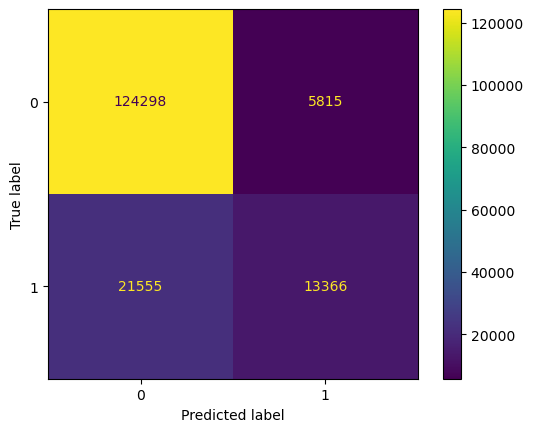

In [70]:
# lets visualize our predictions with a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test,y_pred_2)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

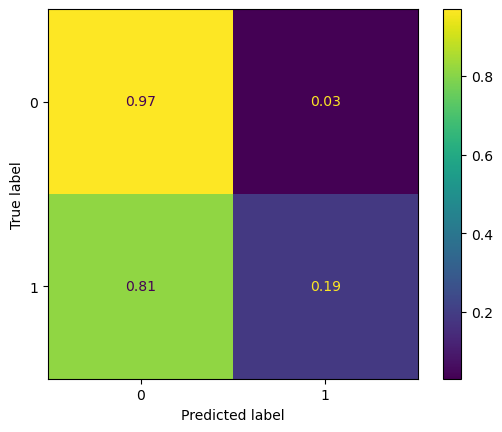

In [396]:
cm_2 = confusion_matrix(y_test,y_pred_2,normalize='true')
cm_display_2= ConfusionMatrixDisplay(confusion_matrix = cm_2)
cm_display_2.plot()
plt.show()

In [373]:
print(classification_report(y_test,y_pred_2))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1608
           1       0.60      0.19      0.28       392

    accuracy                           0.82      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.82      0.77      2000



### Model 3: XGBoost

In [95]:
from xgboost import XGBClassifier

NameError: name 'XGBCLassifier' is not defined

In [97]:
xgb_predictor = XGBClassifier(objective='binary:logsitic')

In [103]:
model_3 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(objective='binary:logistic'))
    ])

In [105]:
model_3.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_columns',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat_columns',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsamp...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [107]:
y_pred_3 = model_3.predict(X_test)

In [109]:
print(classification_report(y_test,y_pred_3))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93    130113
           1       0.78      0.59      0.67     34921

    accuracy                           0.88    165034
   macro avg       0.84      0.77      0.80    165034
weighted avg       0.87      0.88      0.87    165034



### Evaluating Curves and AUC



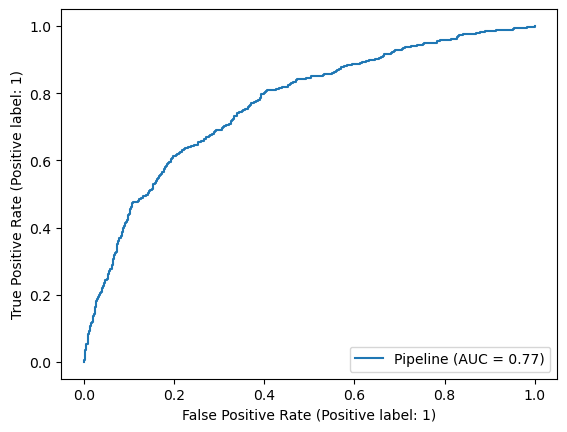

In [413]:
from sklearn.metrics import RocCurveDisplayAU

fig3,ax3 = plt.subplots()

RocCurveDisplay.from_estimator(model_2,X_test,y_test,ax=ax3)

## Summary and Evaluation

We were able to glean some interesting information regarding relationships betwen client age,income, and balance with churn. These require further evaluation and discussion with marketing and appropriate executives. Development of a more accurate model requires further exploration and differenet methodologies, possibly including Neural Networks and/or RandomForestNetworks